# Keypoint regression

Single keypoint regression consists of localizing a keypoint in an image. Here we'll be training on a head pose dataset, where every image has a person in it and the head of the person is annotated. Since keypoint datasets all have different formats, we have to do a bit more manual work to get the task dataset loaded. First we import everything we'll need:

In [4]:
using CairoMakie; CairoMakie.activate!(type="png")
using DataAugmentation
using DelimitedFiles: readdlm
using DLPipelines
using FastAI
using FastAI.Datasets
using FilePathsBase
using FilePathsBase: /
using Images
using StaticArrays

## Creating a task data container

[`datasetpath`](#) downloads the files, but it's up to us to load them into a usable format. In the end, the task data container should contain tuples of an image and a keypoint each.

In [5]:
path = datasetpath("biwi_head_pose")

p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose"

First we create a [`FileDataset`](#) from the directory where the dataset has been downloaded to:

In [6]:
pathdata_base = FileDataset(path)

FileDataset("/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose", 31430 observations)

A `FileDataset` simply treats every file as a single observation. However, that is not what we want here: for every observation we have one image and one annotation file that make up one observation and we want to ignore all other files, like the README. To achieve this, we'll create two data containers containing all the image paths and annotation paths respectively by filtering the container with all paths. 

In [7]:
pathdataimages = filterobs(isimagefile, pathdata_base)
pathdatannots = filterobs(pathdata_base) do p
    occursin("pose", filename(p))
end
pathdata = (pathdataimages, pathdatannots)
getobs(pathdata, 1)

(p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_rgb.jpg", p"/home/lorenz/.julia/datadeps/fastai-biwi_head_pose/biwi_head_pose/01/frame_00003_pose.txt")

Next we need to map functions over each observation that load the data from the files. An image file can be loaded using the [`loadfile`](#) utility. The keypoints have a custom format, so we write a helper function to parse them from a text file. 

In [8]:
readcalibrationfile(p) = readdlm(string(p))[1:3, 1:3]

CAL = readcalibrationfile(path / "01" / "rgb.cal")

function readannotfile(annotpath, cal = CAL)
    ctr = readdlm(string(annotpath))[4,:]
    cx = ctr[1] * cal[1,1]/ctr[3] + cal[1,3]
    cy = ctr[2] * cal[2,2]/ctr[3] + cal[2,3]
    return SVector(cy, cx) .+ 1
end

readannotfile (generic function with 2 methods)

Now we can use [`mapobs`](#) to lazily map the loading function over the container. By specifying a named tuple of functions, the result will be a container of named tuples as well. Note that beside loading the image and keypoint, we also extract the subject ID from the path. We'll use this in a bit for splitting the dataset appropriately and we don't have access to the path information anymore once we have a container of loaded data. 

In [9]:
taskdata = mapobs(
    (
        input = ((ip, ap),) -> loadfile(ip),
        target = ((ip, ap),) -> readannotfile(ap),
        subjectid = ((ip, ap),) -> parse(Int, filename(parent(ip)))
    ),
    pathdata)

mapobs((input = var"#3#6"(), target = var"#4#7"(), subjectid = var"#5#8"()), (DataSubset(::FileDataset, ::Vector{Int64}, ObsDim.Undefined())
 15678 observations, DataSubset(::FileDataset, ::Vector{Int64}, ObsDim.Undefined())
 15678 observations))

In [36]:
obs = getobs(taskdata, 1000)

(input = RGB{N0f8}[RGB{N0f8}(0.0,0.0,0.0) RGB{N0f8}(0.008,0.008,0.008) … RGB{N0f8}(0.047,0.024,0.031) RGB{N0f8}(0.016,0.0,0.0); RGB{N0f8}(0.047,0.047,0.047) RGB{N0f8}(0.906,0.906,0.906) … RGB{N0f8}(0.553,0.529,0.537) RGB{N0f8}(0.067,0.043,0.051); … ; RGB{N0f8}(0.004,0.0,0.016) RGB{N0f8}(0.004,0.0,0.0) … RGB{N0f8}(0.475,0.451,0.451) RGB{N0f8}(0.059,0.039,0.027); RGB{N0f8}(0.004,0.0,0.016) RGB{N0f8}(0.004,0.0,0.0) … RGB{N0f8}(0.059,0.035,0.035) RGB{N0f8}(0.016,0.0,0.0)], target = [259.87126116345524, 401.78323834119755], subjectid = 2)

We can visualize an observation using [`DataAugmentation.showitems`](#) if we wrap the data in item types:

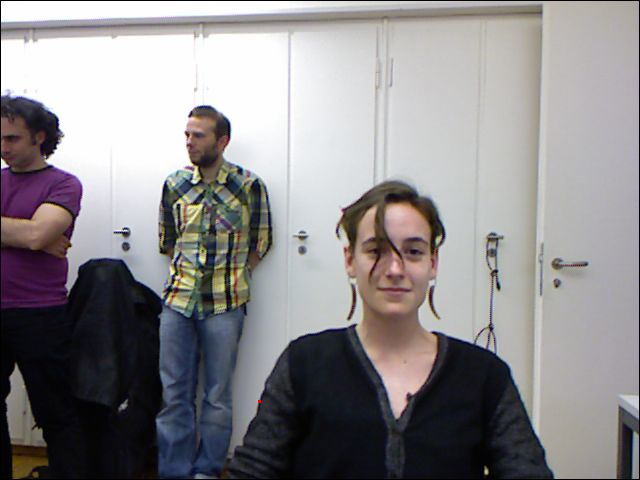

In [37]:
showitems((DataAugmentation.Image(obs.input), Keypoints([obs.target], size(obs.input))))

Before we can start using this data container for training, we need to split into a training and validation dataset. Since there are 13 different persons with many images each, randomly splitting the container does not make sense. The validation dataset would then contain many images that are very similar to those seen in training, and would hence say little about the generalization ability of a model. We instead use the first 12 subjects as a training dataset and validate on the last.

In [12]:
ids = [getobs(taskdata.subjectid, i) for i in 1:nobs(taskdata)]
traindata = datasubset(taskdata, (1:nobs(taskdata))[ids .!= 13])
validdata = datasubset(taskdata, (1:nobs(taskdata))[ids .== 13])
nobs(traindata), nobs(validdata)

(15193, 485)

## The learning method

Next we need to define a [learning method](./learningmethods.md) that encodes and augments each image and keypoint in a form that we can train a model on. We need to create a `LearningMethod` struct for which we can define these transformations. Here we make use of [`ProjectiveTransforms`](#) for resizing, cropping and augmenting the image and keypoint and [`ImagePreprocessing`](#) to reshape and normalize the image.

Note that we're reimplementing a slightly simplified implementation for understanding and a learning method for this task is already in FastAI.jl: [`SingleKeypointRegression`](#).


In [15]:
struct MyKeypointRegression <: LearningMethod
    projections::ProjectiveTransforms
    preprocessing::ImagePreprocessing
end

For training a model, we need to to define how input and target are encoded by implementing the `encode` method and dispatching on our method type, `MyKeypointRegression`. It is important that due to randomness involved in cropping and augmenting, we need to apply the projective transformations to both image and keypoint together. They keypoint is scaled down by the image size and shifted so it falls between -1 and 1 on both axes.

In [16]:
function DLPipelines.encode(method::MyKeypointRegression, context, sample::Union{Tuple, NamedTuple})
    image, keypoint = sample[1], sample[2]
    pimage, pkeypoints = FastAI.run(method.projections, context, (image, [keypoint]))
    x = FastAI.run(method.preprocessing, context, pimage)
    y = collect(Float32.(scalepoint(pkeypoints[1], method.projections.sz)))
    return x, y
end

scalepoint(v, sz) = v .* (2 ./ sz) .- 1

scalepoint (generic function with 1 method)

Now we can create an instance of the method configured to resize and crop the images to 128x128:

In [17]:
sz = (128, 128)
method = MyKeypointRegression(
    ProjectiveTransforms(sz, augmentations=augs_projection(max_warp=0., max_rotate=0.)),
    ImagePreprocessing()
)

MyKeypointRegression(ProjectiveTransforms{2}(
    sz = (128, 128), 
    buffered = true, 
    augmentations = DataAugmentation.ComposedProjectiveTransform{Tuple{DataAugmentation.OneOfProject…
), ImagePreprocessing(
    C = RGB{N0f8}, 
    T = Float32, 
    buffered = true, 
    augmentations = Identity()
))

We can check that each image is resized to `(128, 128)` and the keypoints are normalized:

In [18]:
x, y = encode(method, Training(), getobs(traindata, 1))
summary(x), y

("128×128×3 Array{Float32, 3}", Float32[0.002804497, 0.5428096])

Next we need to define how to turn a model output into a keypoint prediction by defining [`decodeŷ`](#). Here we just need to undo the scaling above so that the keypoint falls back into image pixel coordinates.

In [19]:
function DLPipelines.decodeŷ(method::MyKeypointRegression, context, ŷ)
    return ((ŷ ) .+ 1) ./ (2 ./ method.projections.sz)
end

Now we can check that it runs:

In [20]:
DLPipelines.decodeŷ(method, Training(), y)

2-element Vector{Float64}:
 64.17948913574219
 98.73981475830078

However, we would also like to visualize our data to make sure that after all the encoding it still makes sense and the keypoint is properly aligned with the head on the image. FastAI.jl uses the plotting package Makie.jl and makes it easy [to add visualization support to learning methods](interfaces.md.html#plotting-interface). Here we'll implement `plotxy!` to allow us to inspect the encoded data. 

In [21]:
function FastAI.plotxy!(f, method::MyKeypointRegression, x, y)
    image = FastAI.invert(method.preprocessing, x)
    v = decodeŷ(method, Validation(),  y)
    FastAI._drawkeypoint!(image, v)
    ax1 = f[1, 1] = FastAI.imageaxis(f)
    FastAI.plotimage!(ax1, image)
    return f
end

The above denormalizes the image so it can be inspected and rescales the keypoint. With `plotxy!` defined, we can use `plotbatch` to show a whole batch of data:

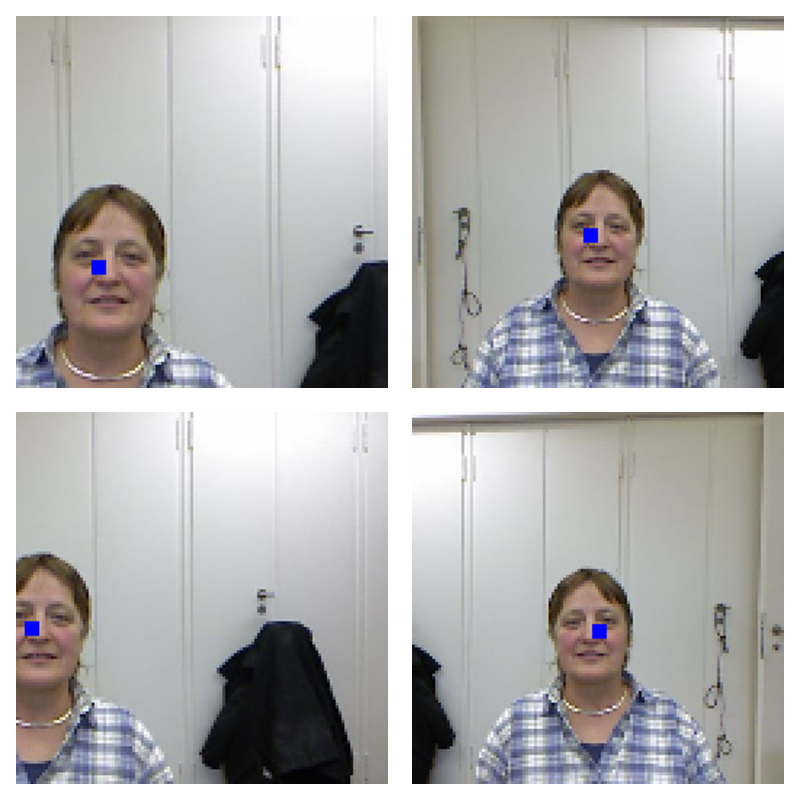

In [22]:
xs, ys = FastAI.makebatch(method, traindata, 1:4)
FastAI.plotbatch(method, xs, ys)

That is looking good! We can see that the keypoint is aligned with center of the head even after heavy augmentation. Now it is finally time to train a model.

## Training

We will finetune a pretrained model provided by Metalhead.jl (make sure to follow the [setup instructions](setup.md) for the right version). Since the pretrained models are trained on classification tasks, we need to remove the last few layers and replace them with layers that regress the keypoint. To make sure this works for any convolutional backbone, we use [`Flux.outputsize`](#) to get the number of channels the backbone outputs, making it easier to connect it with a new regression head.

In [30]:
using Metalhead

backbone = Metalhead.ResNet50(pretrain=true).layers[1:end-3]
h, w, ch, b = Flux.outputsize(backbone, (sz..., 3, 1))
head = FastAI.Models.visionhead(ch, 2, y_range=(-1, 1))
model = Chain(backbone, head);

Next we create a pair of training and validation data loaders. They take care of batching and loading the data in parallel in the background.

In [31]:
traindl, validdl = FastAI.methoddataloaders(traindata, validdata, method)

(eachobsparallel(batchviewcollated() with 950 batches of size 16), eachobsparallel(batchviewcollated() with 16 batches of size 32))

With the addition of an optimizer and a loss function, we can now create a [`Learner`](#) and start training:

In [32]:
learner = Learner(
    model,
    (traindl, validdl),
    Flux.ADAM(),
    Flux.mse,
    ToGPU())

Learner()

In [33]:
finetune!(learner, 3)

Epoch 1 TrainingPhase(): 100%|██████████████████████████| Time: 0:05:21:11


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   1.0 │ 0.09887 │
└───────────────┴───────┴─────────┘


Epoch 1 ValidationPhase(): 100%|████████████████████████| Time: 0:00:10


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   1.0 │ 0.00271 │
└─────────────────┴───────┴─────────┘


Epoch 2 TrainingPhase(): 100%|██████████████████████████| Time: 0:02:04


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   2.0 │ 0.02045 │
└───────────────┴───────┴─────────┘


Epoch 2 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   2.0 │ 0.00295 │
└─────────────────┴───────┴─────────┘


Epoch 3 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:54


┌───────────────┬───────┬────────┐
│         Phase │ Epoch │   Loss │
├───────────────┼───────┼────────┤
│ TrainingPhase │   3.0 │ 0.0172 │
└───────────────┴───────┴────────┘


Epoch 3 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   3.0 │ 0.00119 │
└─────────────────┴───────┴─────────┘


Epoch 4 TrainingPhase(): 100%|██████████████████████████| Time: 0:01:54


┌───────────────┬───────┬─────────┐
│         Phase │ Epoch │    Loss │
├───────────────┼───────┼─────────┤
│ TrainingPhase │   4.0 │ 0.01363 │
└───────────────┴───────┴─────────┘


Epoch 4 ValidationPhase(): 100%|████████████████████████| Time: 0:00:00


┌─────────────────┬───────┬─────────┐
│           Phase │ Epoch │    Loss │
├─────────────────┼───────┼─────────┤
│ ValidationPhase │   4.0 │ 0.00224 │
└─────────────────┴───────┴─────────┘


Learner()

The loss is going down which is a good sign, but visualizing the predictions against the ground truth will give us a better idea of how well the model performs. Similar to the above `plotxy!`, there is a function [`plotprediction!`](#) that we can extend to visualize a prediction and its ground truth. We'll color the ground truth green and the prediction red.

In [34]:
function FastAI.plotprediction!(f, method::MyKeypointRegression, x, ŷ, y)
    image = FastAI.invert(method.preprocessing, x)
    v = decodeŷ(method, Validation(), y)
    v̂ = decodeŷ(method, Validation(), ŷ)
    FastAI._drawkeypoint!(image, v, c = RGB(0, 1, 0))
    FastAI._drawkeypoint!(image, v̂, c = RGB(1, 0, 0))
    ax1 = f[1, 1] = FastAI.imageaxis(f)
    FastAI.plotimage!(ax1, image)
    return f
end

Now we can run the model on a batch from the validation dataset and see how it performs.

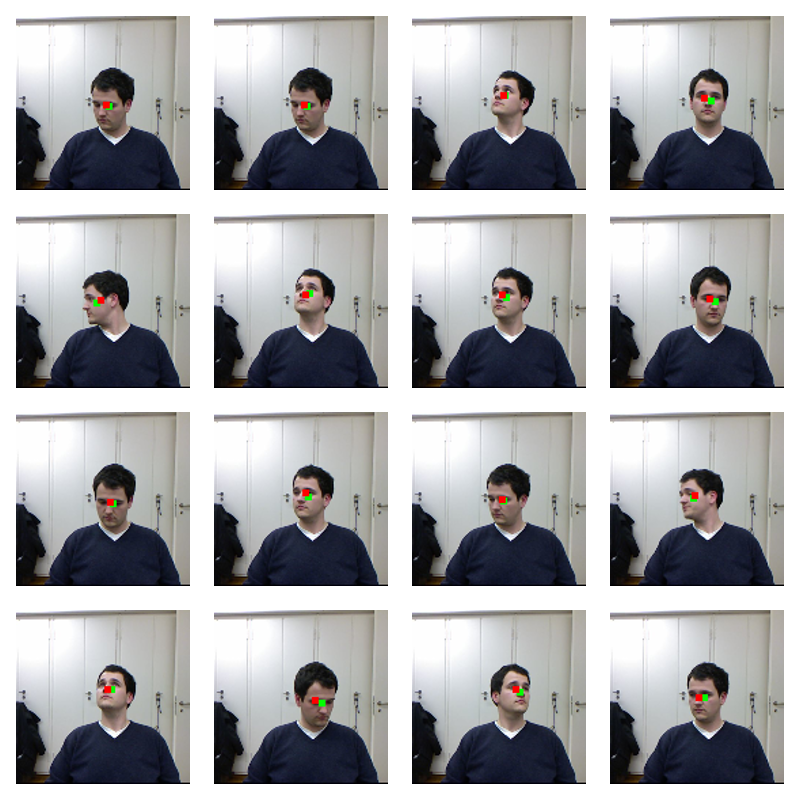

In [35]:
xs, ys = FastAI.makebatch(method, validdata, rand(1:485, 16), context = Validation())
ŷs = learner.model(gpu(xs)) |> cpu
FastAI.plotpredictions(method, xs, cpu(ŷs), ys)